<a href="https://colab.research.google.com/github/Mohamed-Mohamed-Ibrahim/Face-Recognition/blob/main/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipykernel_31/3798670741.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=30, cmap='viridis')


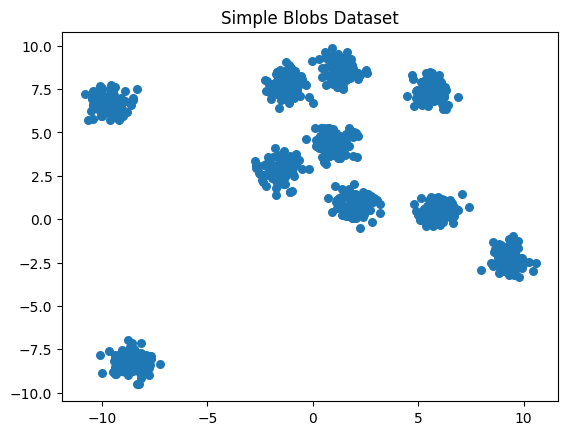

In [105]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic data
X, y = make_blobs(n_samples=1000, centers=10, cluster_std=0.50, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=30, cmap='viridis')
plt.title("Simple Blobs Dataset")
plt.show()


In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load FashionMNIST with transform
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Collect up to 100 samples
X, y = [], []
for image, label in train_dataset:
    if len(X) == 100:
        break
    image_numpy = image.numpy().squeeze()  # (28, 28)
    X.append(image_numpy)
    y.append(label)

# Convert to NumPy and reshape
X = np.array(X).reshape(len(X), -1)  # (100, 784)
y = np.array(y)



# Normalize to [0, 1]
X = X / 255.0

# Explicitly replace infs with nan, then drop all rows with any nans
X[np.isinf(X)] = np.nan
valid_mask = ~np.isnan(X).any(axis=1)
X = X[valid_mask]
y = y[valid_mask]

# Ensure no NaNs or infs remain
assert not np.isnan(X).any(), "NaNs still in X"
assert not np.isinf(X).any(), "Infs still in X"

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"Cleaned X shape: {X.shape}")
print(f"Cleaned y shape: {y.shape}")


Cleaned X shape: (100, 784)
Cleaned y shape: (100,)


In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40)  # Reduce to 50 components (you can adjust this)
print(f"Original shape: {X.shape}")
X = pca.fit_transform(X)

print(f"PCA-reduced shape: {X.shape}")

Original shape: (100, 784)
PCA-reduced shape: (100, 40)


In [106]:
from sklearn.model_selection import train_test_split

# Let's say you already have:
# X_pca: shape (60000, 50)
# y:     shape (60000,)

# Split into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")


Train shape: (800, 2)
Test shape:  (200, 2)


In [122]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import multivariate_normal


class GMM(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=1, tol=0.001, reg_covar=1e-06, max_iter=100, verbose=False, n_init=10):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.max_iter = max_iter
        self.verbose = verbose
        self.n_init = n_init
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None
        self.cluster_meanings = np.zeros(n_components)

    def fit(self, X):
        best_m = None
        best_c = None
        best_w = None
        best_log_likelihood = -np.inf

        for _ in range(self.n_init):
            self.__fit(X)
            ll = self.score(X)
            if ll > best_log_likelihood:
                best_log_likelihood = ll
                best_m = self.means_
                best_c = self.covariances_
                best_w = self.weights_
            self.means_ = None
            self.covariances_ = None
            self.weights_ = None
        self.means_ = best_m
        self.covariances_ = best_c
        self.weights_ = best_w


    def __fit(self, X):

        n_samples, n_features = X.shape
        self.means_ = np.random.rand(self.n_components, n_features)*20 - 10
        self.covariances_ = np.zeros((self.n_components, n_features, n_features))
        for i in range(self.n_components):
            self.covariances_[i] = np.eye(n_features)
        self.weights_ = (1/self.n_components) + np.zeros(self.n_components)
        log_likelihood_old = -np.inf

        r = np.zeros((self.n_components, n_samples))

        for _ in range(self.max_iter):

            if self.verbose and self.max_iter % 50 == 0:
                print(f"Iteration: {_} -> log-loss -> {log_likelihood_old}")
            
            # E-step
            # Assign r using posterior probability
            for i in range(self.n_components):
                r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, self.means_[i], self.covariances_[i], allow_singular=True)

            # Normalization
            for i in range(n_samples):
                r[:, i] = r[:, i] / np.sum(r[:, i])

            old_w = self.weights_.copy()
            old_m = self.means_.copy()
            old_c = self.covariances_.copy()

            # M-step
            for i in range(self.n_components):
                denom = np.sum(r[i, :])
                if denom == 0:
                    continue
                self.weights_[i] = np.sum(r[i, :]) / n_samples

                # for j in range(n_features):
                #     self.means_[i][j] = np.sum(r[i, :] * X[:, j]) / np.sum(r[i, :])
                self.means_[i] = (r[i, :, np.newaxis] * X).sum(axis=0) / np.sum(r[i, :])
                    # for k in range(n_features):
                    #     self.covariances_[i][j, k] = np.sum(r[i, :] * (X[:, j] - self.means_[i][j]) * (X[:, k] - self.means_[i][k])) / np.sum(r[i, :])

                diff = X - self.means_[i]
                self.covariances_[i] = (r[i, :, np.newaxis, np.newaxis] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / np.sum(r[i, :])

                # Regularize covariance
                self.covariances_[i] += self.reg_covar * np.eye(n_features)

            # if np.all(np.abs(old_w - self.weights_) < self.tol) and np.all(np.abs(old_m - self.means_) < self.tol) and np.all(np.abs(old_c - self.covariances_) < self.tol):
                # break
            log_likelihood_new = self.score(X)
            if np.abs(log_likelihood_new - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood_new

    def predict(self, X):
        n_samples = len(X)

        r = np.zeros((self.n_components, n_samples))

        for i in range(self.n_components):
            r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, self.means_[i], self.covariances_[i], allow_singular=True)

        return np.argmax(r, axis=0)

    def score(self, X):
        ll = []
        for d in X:
            tot = 0
            for k in range(self.n_components):
                tot += self.weights_[k] * multivariate_normal.pdf(d, mean=self.means_[k], cov=self.covariances_[k], allow_singular=True)
            ll.append(np.log(tot))
        return np.sum(ll)

# Testing

# Resourses

- https://www.geeksforgeeks.org/how-to-load-fashion-mnist-dataset-using-pytorch/
- https://youtu.be/wT2yLNUfyoM
- https://scikitlearn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
- https://github.com/scikit-learn/scikit-learn/blob/98ed9dc73/sklearn/mixture/_gaussian_mixture.py#L509
- https://github.com/mr-easy/GMM-EM-Python/tree/master

# Evaluation

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

# Ensure X, y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_components_list = [20, 40, 60]

for n in n_components_list:
    print(f"\n===== n_components = {n} =====")

    # ▶️ Custom GMM
    gmm_custom = GMM(n_components=n, max_iter=50, tol=1e-3, n_init=3, verbose=False)
    gmm_custom.fit(X_train)
    gmm_custom.clusters_meaning(X_train, y_train)
    y_pred_custom = gmm_custom.predict(X_test)
    y_pred_custom_mapped = gmm_custom.cluster_meanings[y_pred_custom]

    acc_custom = accuracy_score(y_test, y_pred_custom_mapped)
    f1_custom = f1_score(y_test, y_pred_custom_mapped, average='macro')

    print("\n[Custom GMM]")
    print(f"Accuracy: {acc_custom:.4f}")
    print(f"F1 Score:  {f1_custom:.4f}")
    print(confusion_matrix(y_test, y_pred_custom_mapped))

    # ▶️ Sklearn GaussianMixture
    gmm_sklearn = GaussianMixture(n_components=n, max_iter=50, tol=1e-3, n_init=3, random_state=42)
    gmm_sklearn.fit(X_train)
    y_pred_sklearn = gmm_sklearn.predict(X_test)

    # Map sklearn GMM clusters to labels
    def map_clusters_to_labels(y_true, clusters):
        from scipy.stats import mode
        labels = np.zeros(np.max(clusters) + 1, dtype=int)
        for i in range(len(labels)):
            mask = clusters == i
            if np.any(mask):
                labels[i] = mode(y_true[mask], keepdims=False).mode
        return labels[clusters]

    y_pred_sklearn_mapped = map_clusters_to_labels(y_train, gmm_sklearn.predict(X_train))[gmm_sklearn.predict(X_test)]

    acc_sklearn = accuracy_score(y_test, y_pred_sklearn_mapped)
    f1_sklearn = f1_score(y_test, y_pred_sklearn_mapped, average='macro')

    print("\n[Sklearn GMM]")
    print(f"Accuracy: {acc_sklearn:.4f}")
    print(f"F1 Score:  {f1_sklearn:.4f}")
    print(confusion_matrix(y_test, y_pred_sklearn_mapped))

    # ▶️ KNN
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)

    acc_knn = accuracy_score(y_test, y_pred_knn)
    f1_knn = f1_score(y_test, y_pred_knn, average='macro')

    print("\n[KNN]")
    print(f"Accuracy: {acc_knn:.4f}")
    print(f"F1 Score:  {f1_knn:.4f}")
    print(confusion_matrix(y_test, y_pred_knn))


# GMM vs GaussianMixture

Iteration 0: log-likelihood = -8253.648626
Iteration 10: log-likelihood = -3476.315932
Iteration 20: log-likelihood = -3475.895281
Iteration 30: log-likelihood = -3475.753156
Iteration 40: log-likelihood = -3475.474733
Iteration 50: log-likelihood = -3472.554775
Iteration 60: log-likelihood = -3471.681784
Iteration 70: log-likelihood = -3471.559341
Iteration 80: log-likelihood = -3471.457412
Iteration 90: log-likelihood = -3471.052531
Iteration 0: log-likelihood = -10444.746047
Iteration 10: log-likelihood = -3207.623937
Iteration 20: log-likelihood = -3207.328617
Iteration 30: log-likelihood = -3207.230580
Iteration 40: log-likelihood = -3207.183479
Iteration 50: log-likelihood = -3206.991937
Iteration 60: log-likelihood = -3204.293388
Iteration 70: log-likelihood = -3204.288070
Converged at iteration 74
Iteration 0: log-likelihood = -9680.629888
Iteration 10: log-likelihood = -3320.520544
Iteration 20: log-likelihood = -3238.164998
Iteration 30: log-likelihood = -3202.901645
Iteratio

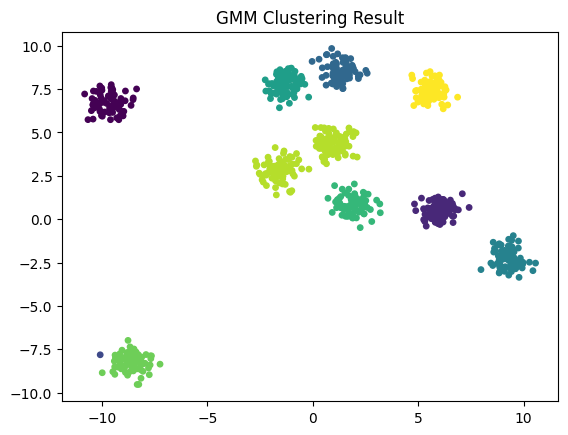

In [130]:
from sklearn.mixture import GaussianMixture
gmm = GMM(n_components=10, tol=1e-6, max_iter=100, n_init=10, verbose=True)
# gmm = GaussianMixture(n_components=10, tol=1e-6, max_iter=100, n_init=10, verbose=True)
gmm.fit(X_train)
labels = gmm.predict(X_train)



plt.scatter(X_train[:, 0], X_train[:, 1], c=labels, s=15, cmap='viridis')
plt.title("GMM Clustering Result")
plt.show()


In [131]:
def clusters_meaning(X, y, n_components):
    n_pred_clusters = n_components
    n_classes = len(np.unique(y))

    cluster_map = np.zeros((n_pred_clusters, n_classes), dtype=int)

    for i in range(len(X)):
        cluster_map[X[i], y[i]] += 1

    cluster_meanings = np.zeros(n_pred_clusters, dtype=int)
    for i, row in enumerate(cluster_map):
        cluster_meanings[i] = np.argmax(row)
    return cluster_meanings

y_pred = gmm.predict(X_train)
y_pred_sklearn_mapped = clusters_meaning(y_pred, y_train, 10)[y_pred]

acc_sklearn = accuracy_score(y_train, y_pred_sklearn_mapped)
f1_sklearn = f1_score(y_train, y_pred_sklearn_mapped, average='macro')

print("\n[GMM]")
print(f"Accuracy: {acc_sklearn:.4f}")
print(f"F1 Score:  {f1_sklearn:.4f}")
print(confusion_matrix(y_train, y_pred_sklearn_mapped))



[GMM]
Accuracy: 0.9000
F1 Score:  0.8667
[[80  0  0  0  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0  0  0  0]
 [80  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 80  0  0  0  0  0  0]
 [ 0  0  0  0 80  0  0  0  0  0]
 [ 0  0  0  0  0 80  0  0  0  0]
 [ 0  0  0  0  0  0 80  0  0  0]
 [ 0  0  0  0  0  0  0 80  0  0]
 [ 0  0  0  0  0  0  0  0 80  0]
 [ 0  0  0  0  0  0  0  0  0 80]]


In [132]:
def clusters_meaning(X, y, n_components):
    n_pred_clusters = n_components
    n_classes = len(np.unique(y))

    cluster_map = np.zeros((n_pred_clusters, n_classes), dtype=int)

    for i in range(len(X)):
        cluster_map[X[i], y[i]] += 1

    cluster_meanings = np.zeros(n_pred_clusters, dtype=int)
    for i, row in enumerate(cluster_map):
        cluster_meanings[i] = np.argmax(row)
    return cluster_meanings

y_pred = gmm.predict(X_test)
y_pred_sklearn_mapped = clusters_meaning(y_pred, y_test, 10)[y_pred]

acc_sklearn = accuracy_score(y_test, y_pred_sklearn_mapped)
f1_sklearn = f1_score(y_test, y_pred_sklearn_mapped, average='macro')

print("\n[GMM]")
print(f"Accuracy: {acc_sklearn:.4f}")
print(f"F1 Score:  {f1_sklearn:.4f}")
print(confusion_matrix(y_test, y_pred_sklearn_mapped))



[GMM]
Accuracy: 0.9000
F1 Score:  0.8667
[[20  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0 20]]


# Fine Tuning 

In [ ]:
from sklearn.model_selection import GridSearchCV

gmmfm = GMM()

parameters = {
    'n_components': [1, 2, 3, 4],
    'tol': [1e-3, 1e-4],
    'reg_covar': [1e-6, 1e-5],
    'max_iter': [100],
    'n_init': [1, 5]
}

clf = GridSearchCV(gmmfm, parameters)

clf.fit(X)

In [23]:
sorted(clf.best_params_.items())

[('max_iter', 100),
 ('n_components', 4),
 ('n_init', 5),
 ('reg_covar', 1e-06),
 ('tol', 0.0001)]

# Other Implementation

In [127]:
# Chatgpt
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import multivariate_normal


class GMM(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=1, tol=0.001, reg_covar=1e-06, max_iter=100, verbose=False, n_init=10):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.max_iter = max_iter
        self.verbose = verbose
        self.n_init = n_init
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None
        self.cluster_meanings = np.zeros(n_components)

    def fit(self, X):
        best_m = None
        best_c = None
        best_w = None
        best_log_likelihood = -np.inf

        for _ in range(self.n_init):
            self._fit_once(X)
            ll = self.score(X)
            if ll > best_log_likelihood:
                best_log_likelihood = ll
                best_m = self.means_
                best_c = self.covariances_
                best_w = self.weights_
            self.means_ = None
            self.covariances_ = None
            self.weights_ = None

        self.means_ = best_m
        self.covariances_ = best_c
        self.weights_ = best_w
    
    def _fit_once(self, X):
        n_samples, n_features = X.shape
        self.means_ = np.random.rand(self.n_components, n_features) * 20 - 10
        self.covariances_ = np.array([np.eye(n_features) for _ in range(self.n_components)])
        self.weights_ = np.ones(self.n_components) / self.n_components
    
        r = np.zeros((self.n_components, n_samples))
        log_likelihood_old = -np.inf  # initialize
    
        for it in range(self.max_iter):
            if self.verbose and it % 10 == 0:
                print(f"Iteration {it}: log-likelihood = {self.score(X):.6f}")
    
    
            # E-step
            for i in range(self.n_components):
                r[i, :] = self.weights_[i] * multivariate_normal.pdf(
                    X, self.means_[i], self.covariances_[i], allow_singular=True
                )
            r_sum = np.sum(r, axis=0) + 1e-12
            r /= r_sum
    
            # Save old parameters
            old_w = self.weights_.copy()
            old_m = self.means_.copy()
            old_c = self.covariances_.copy()
    
            # M-step
            for i in range(self.n_components):
                resp = r[i, :]
                total_resp = np.sum(resp)
                if total_resp == 0:
                    continue
    
                self.weights_[i] = total_resp / n_samples
                self.means_[i] = (resp[:, np.newaxis] * X).sum(axis=0) / total_resp
    
                diff = X - self.means_[i]
                self.covariances_[i] = (resp[:, np.newaxis, np.newaxis] *
                                        np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / total_resp
                self.covariances_[i] += self.reg_covar * np.eye(n_features)
    
            # Log-likelihood convergence check
            log_likelihood_new = self.score(X)
            if np.abs(log_likelihood_new - log_likelihood_old) < self.tol:
                if self.verbose:
                    print(f"Converged at iteration {it}")
                break
            log_likelihood_old = log_likelihood_new


    def predict(self, X):
        n_samples = len(X)
        r = np.zeros((self.n_components, n_samples))

        for i in range(self.n_components):
            r[i, :] = self.weights_[i] * multivariate_normal.pdf(
                X, self.means_[i], self.covariances_[i], allow_singular=True
            )

        return np.argmax(r, axis=0)

    def score(self, X):
        ll = 0.0
        for d in X:
            tot = 0.0
            for k in range(self.n_components):
                tot += self.weights_[k] * multivariate_normal.pdf(
                    d, mean=self.means_[k], cov=self.covariances_[k], allow_singular=True
                )
            ll += np.log(tot + 1e-12)
        return ll


### Deep seek

In [124]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import multivariate_normal
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class GMM(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=1, tol=0.001, reg_covar=1e-06, max_iter=100, verbose=False, n_init=10):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.max_iter = max_iter
        self.verbose = verbose
        self.n_init = n_init
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None
        self.cluster_meanings_ = None
        self.converged_ = False
        self.n_iter_ = 0

    def fit(self, X, y=None):
        """Fit the model to the data X.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data
        y : Ignored
            Not used, present for API consistency
            
        Returns
        -------
        self : object
            The fitted estimator
        """
        X = check_array(X)
        n_samples, n_features = X.shape

        best_means = None
        best_covariances = None
        best_weights = None
        best_log_likelihood = -np.inf

        for init in range(self.n_init):
            if self.verbose:
                print(f"Initialization {init + 1}/{self.n_init}")

            # Reset parameters for each initialization
            self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
            self.covariances_ = np.array([np.cov(X.T) + self.reg_covar * np.eye(n_features) 
                                         for _ in range(self.n_components)])
            self.weights_ = np.ones(self.n_components) / self.n_components

            log_likelihood_old = -np.inf
            self.converged_ = False

            for iteration in range(self.max_iter):
                self.n_iter_ = iteration + 1

                # E-step: Compute responsibilities
                r = np.zeros((self.n_components, n_samples))
                for i in range(self.n_components):
                    r[i, :] = self.weights_[i] * multivariate_normal.pdf(
                        X, self.means_[i], self.covariances_[i], allow_singular=True)

                # Avoid numerical issues
                r = np.where(r < np.finfo(r.dtype).eps, np.finfo(r.dtype).eps, r)
                r /= np.sum(r, axis=0, keepdims=True)

                # Store old parameters for convergence check
                old_means = self.means_.copy()
                old_covariances = self.covariances_.copy()
                old_weights = self.weights_.copy()

                # M-step: Update parameters
                for i in range(self.n_components):
                    resp_sum = np.sum(r[i, :])
                    if resp_sum == 0:
                        continue

                    self.weights_[i] = resp_sum / n_samples
                    self.means_[i] = np.sum(r[i, :, np.newaxis] * X, axis=0) / resp_sum

                    diff = X - self.means_[i]
                    self.covariances_[i] = np.dot(r[i, :] * diff.T, diff) / resp_sum
                    self.covariances_[i].flat[::n_features + 1] += self.reg_covar

                # Check convergence
                current_log_likelihood = self._compute_log_likelihood(X)
                if np.abs(current_log_likelihood - log_likelihood_old) < self.tol:
                    self.converged_ = True
                    if self.verbose:
                        print(f"Converged at iteration {iteration}")
                    break
                log_likelihood_old = current_log_likelihood

            # Keep track of best initialization
            current_score = self.score(X)
            if current_score > best_log_likelihood:
                best_log_likelihood = current_score
                best_means = self.means_.copy()
                best_covariances = self.covariances_.copy()
                best_weights = self.weights_.copy()

        # Store best parameters
        self.means_ = best_means
        self.covariances_ = best_covariances
        self.weights_ = best_weights

        return self

    def predict(self, X):
        """Predict the cluster labels for the data.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Data to predict
            
        Returns
        -------
        labels : ndarray of shape (n_samples,)
            Cluster labels
        """
        check_is_fitted(self)
        X = check_array(X)
        
        n_samples = X.shape[0]
        r = np.zeros((self.n_components, n_samples))

        for i in range(self.n_components):
            r[i, :] = self.weights_[i] * multivariate_normal.pdf(
                X, self.means_[i], self.covariances_[i], allow_singular=True)

        return np.argmax(r, axis=0)

    def score(self, X):
        """Compute the log-likelihood of X under the model.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Data to score
            
        Returns
        -------
        log_likelihood : float
            Log-likelihood of the data
        """
        check_is_fitted(self)
        X = check_array(X)
        return self._compute_log_likelihood(X)

    def _compute_log_likelihood(self, X):
        """Helper function to compute log-likelihood."""
        log_prob = np.zeros((X.shape[0], self.n_components))
        
        for k in range(self.n_components):
            log_prob[:, k] = np.log(self.weights_[k]) + multivariate_normal.logpdf(
                X, mean=self.means_[k], cov=self.covariances_[k])
        
        return np.sum(np.logaddexp.reduce(log_prob, axis=1))

    def clusters_meaning(self, X, y):
        """Compute the most common class in each cluster.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data
        y : array-like of shape (n_samples,)
            Target labels
            
        Returns
        -------
        cluster_meanings : ndarray of shape (n_components,)
            Most common class in each cluster
        """
        X, y = check_X_y(X, y)
        pred = self.predict(X)
        n_classes = len(np.unique(y))
        
        cluster_map = np.zeros((self.n_components, n_classes), dtype=int)
        
        for i in range(len(X)):
            cluster_map[pred[i], y[i]] += 1
        
        self.cluster_meanings_ = np.argmax(cluster_map, axis=1)
        return self.cluster_meanings_